Run emll on TopB
- compare elasticity, CCC, and FCC results to v-based results

# Set up 

In [ ]:
SEED = 1
import random

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pytensor.tensor as at
import pytensor
floatX = pytensor.config.floatX
import pymc as pm

import cobra
import os

from scipy import stats
import scipy as sp
import math

import gzip
import cloudpickle

In [ ]:
import emll
from emll.pytensor_utils import LeastSquaresSolve

In [ ]:
os.chdir('../../..')
from src import antemll, util_pytensor
os.chdir('notebooks/topologyB/all_data/')

## Perturbing enzymes

In [ ]:
ant ='../../../models/Antimony/TopologyB-noReg.ant'  
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.7241056990445864e-15

In [ ]:
pt_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [ ]:
data_file01 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_0.1.csv'
data_file02 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_0.2.csv'
data_file03 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_0.3.csv'
data_file04 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_0.4.csv'
data_file05 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_0.5.csv'

data_file15 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_1.5.csv'
data_file3 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_3.csv'
data_file5 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_5.csv'
data_file7 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_7.csv'
data_file100 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_10.csv'


In [ ]:
BMCA_obj01 = antemll.antemll(ant, data_file01, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj02 = antemll.antemll(ant, data_file02, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj03 = antemll.antemll(ant, data_file03, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj04 = antemll.antemll(ant, data_file04, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj05 = antemll.antemll(ant, data_file05, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')

BMCA_obj15 = antemll.antemll(ant, data_file15, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj3 = antemll.antemll(ant, data_file3, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj5 = antemll.antemll(ant, data_file5, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj7 = antemll.antemll(ant, data_file7, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj100 = antemll.antemll(ant, data_file100, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')


../../../models/Antimony/TopologyB_cobra.ant
Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-24


No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


In [ ]:
def run_prior_predictive(BMCA_obj):
    ll = emll.LinLogLeastNorm(BMCA_obj.N, BMCA_obj.Ex.to_numpy(), BMCA_obj.Ey.to_numpy(), BMCA_obj.v_star, driver='gelsy')
    
    with pm.Model() as pymc_model:
        # Initialize elasticities
        # Ex and Ey have to be shape (rxns, mets)
        Ex_t = pm.Deterministic('Ex', emll.util.initialize_elasticity(BMCA_obj.Ex.to_numpy().T, 'Ex', b=0.05, sd=1, alpha=5))
        Ey_t = pm.Deterministic('Ey', emll.util.initialize_elasticity(BMCA_obj.Ey.to_numpy().T, 'Ey', b=0.05, sd=1, alpha=5))

        trace_prior = pm.sample_prior_predictive(random_seed=SEED)

    return trace_prior


# Running ADVI

In [ ]:
def run_ADVI(BMCA_obj):
    np.random.seed(SEED)
    random.seed(SEED)

    ll = emll.LinLogLeastNorm(BMCA_obj.N, BMCA_obj.Ex.to_numpy(), BMCA_obj.Ey.to_numpy(), BMCA_obj.v_star, driver='gelsy')
    
    with pm.Model() as pymc_model:
        # Initialize elasticities
        # Ex and Ey have to be shape (rxns, mets)
        Ex_t = pm.Deterministic('Ex', emll.util.initialize_elasticity(BMCA_obj.Ex.to_numpy().T, 'Ex', b=0.05, sigma=1, alpha=5))
        Ey_t = pm.Deterministic('Ey', emll.util.initialize_elasticity(BMCA_obj.Ey.to_numpy().T, 'Ey', b=0.05, sigma=1, alpha=5))

        # Error priors. 
        v_err = pm.HalfNormal('v_error', sigma=0.05, initval=.1)
        x_err = pm.HalfNormal('x_error', sigma=0.05, initval=.1)

        # Calculate steady-state concentrations and fluxes from elasticities
        chi_ss, v_hat_ss = ll.steady_state_pytensor(Ex_t, Ey_t, BMCA_obj.en.values, BMCA_obj.yn.values)
        
        # Error distributions for observed steady-state concentrations and fluxes
        chi_obs = pm.Normal('chi_obs', mu=chi_ss, sigma=x_err, observed=BMCA_obj.xn.values)
        v_hat_obs = pm.Normal('v_hat_obs', mu=v_hat_ss.squeeze(),
                            sigma=v_err, observed=BMCA_obj.vn.squeeze())
        
        N_ITERATIONS = 150000

    with pymc_model:
        advi = pm.ADVI(random_seed=SEED)
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n= N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    with pymc_model:
        trace = approx.sample(draws=1000, random_seed=SEED)
        ppc_vi = pm.sample_posterior_predictive(trace)
    
    return trace, ppc_vi

Finished [100%]: Average Loss = 436.23


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = 114.36


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = -185.92


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = -423.96


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = -647.5


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = -1,187.6


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = -415.61


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = -149.42


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = 3.7605


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = 188.36


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


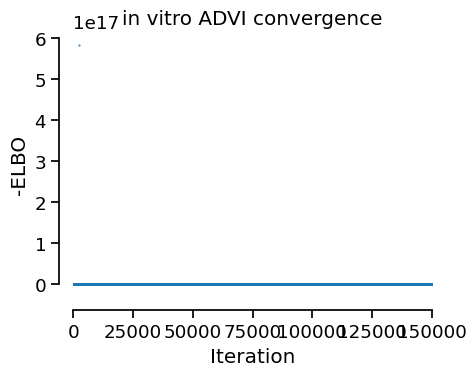

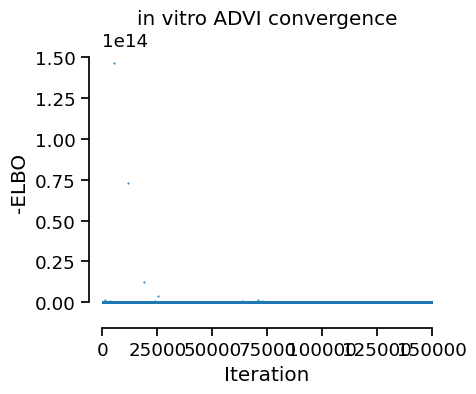

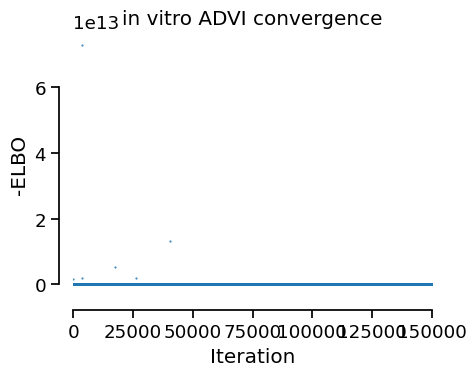

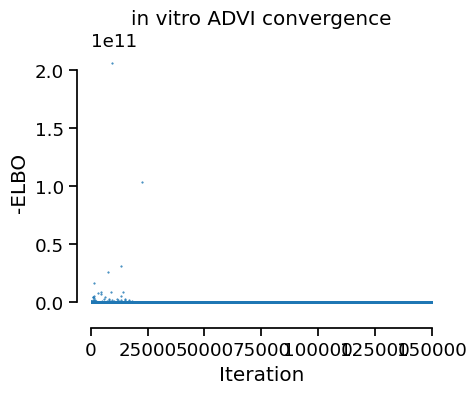

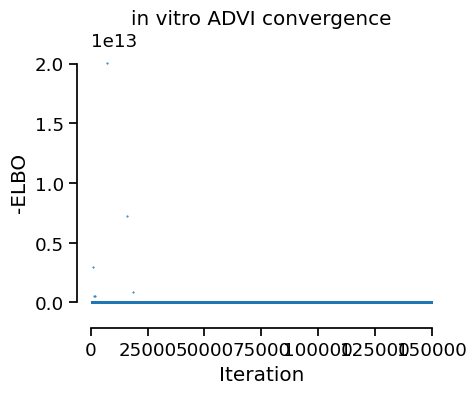

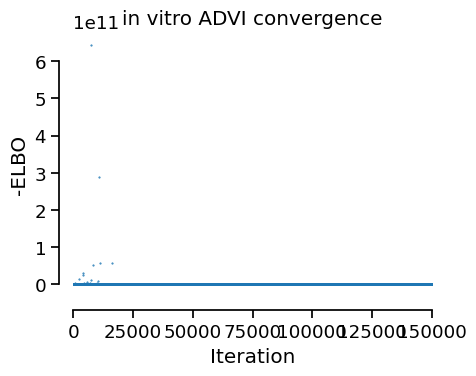

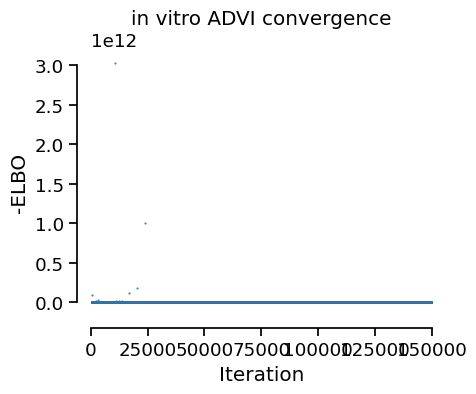

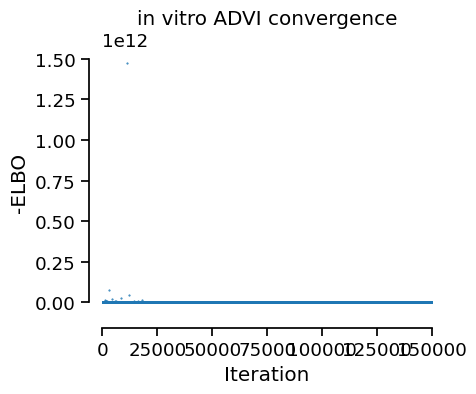

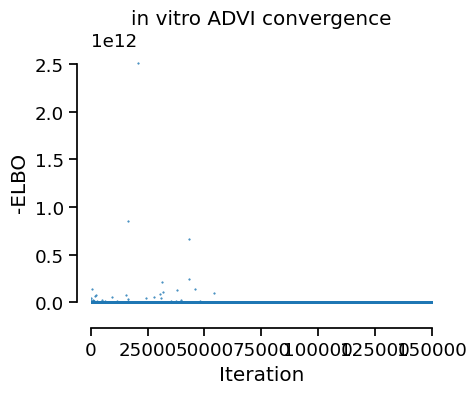

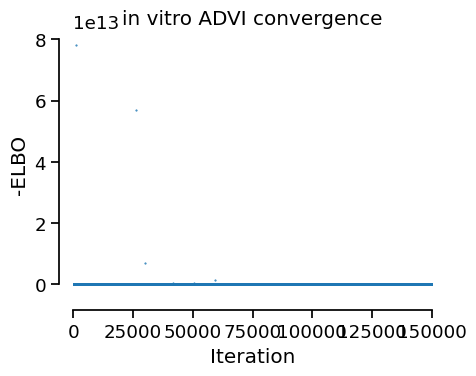

In [10]:
trace01, ppc01 = run_ADVI(BMCA_obj01)
trace02, ppc02 = run_ADVI(BMCA_obj02)
trace03, ppc03 = run_ADVI(BMCA_obj03)
trace04, ppc04 = run_ADVI(BMCA_obj04)
trace05, ppc05 = run_ADVI(BMCA_obj05)

trace15, ppc15 = run_ADVI(BMCA_obj15)
trace3, ppc3 = run_ADVI(BMCA_obj3)
trace5, ppc5 = run_ADVI(BMCA_obj5)
trace7, ppc7 = run_ADVI(BMCA_obj7)
trace100, ppc100 = run_ADVI(BMCA_obj100)

### saving trace data

In [11]:
with gzip.open("../../../data/results/tracePickles/cowboy.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace01":trace01,
                "trace02":trace02,
                "trace03":trace03,
                "trace04":trace04,
                "trace05":trace05,
                "trace15":trace15,
                "trace3":trace3,
                "trace5":trace5,
                "trace7":trace7,
                "trace100":trace100,
                "ppc01":ppc01,
                "ppc02":ppc02,
                "ppc03":ppc03,
                "ppc04":ppc04,
                "ppc05":ppc05,
                "ppc15":ppc15,
                "ppc3":ppc3,
                "ppc5":ppc5,
                "ppc7":ppc7,
                "ppc100":ppc100
                },
                f,
            )

# Analysis

from here, we will switch to the `gayles` conda environment

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp
import math

import cloudpickle
import gzip

os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyB/all_data/')

ant ='../../../models/antimony/TopologyB.ant'  
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

pt_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

data_file01 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_0.1.csv'
data_file02 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_0.2.csv'
data_file03 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_0.3.csv'
data_file04 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_0.4.csv'
data_file05 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_0.5.csv'

data_file15 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_1.5.csv'
data_file3 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_3.csv'
data_file5 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_5.csv'
data_file7 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_7.csv'
data_file100 = '../../../data/generated_data/topologyB-noReg/topologyB-noReg_10.csv'

BMCA_obj01 = antemll.antemll(ant, data_file01, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj02 = antemll.antemll(ant, data_file02, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj03 = antemll.antemll(ant, data_file03, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj04 = antemll.antemll(ant, data_file04, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj05 = antemll.antemll(ant, data_file05, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')

BMCA_obj15 = antemll.antemll(ant, data_file15, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj3 = antemll.antemll(ant, data_file3, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj5 = antemll.antemll(ant, data_file5, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj7 = antemll.antemll(ant, data_file7, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj100 = antemll.antemll(ant, data_file100, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


In [2]:
picklefolder = '../../../data/results/tracePickles/'
with gzip.open(picklefolder + 'cowboy.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [3]:
picklefolder = '../../../data/results/tracePickles/'
with gzip.open(picklefolder + 'topologyB-noReg_allData_traces.pgz', "rb") as f:
    vtraces = cloudpickle.load(f, encoding='bytes')

In [4]:
trace01=traces['trace01']
trace02=traces['trace02']
trace03=traces['trace03']
trace04=traces['trace04']
trace05=traces['trace05']

trace15=traces['trace15']
trace3=traces['trace3']
trace5=traces['trace5']
trace7=traces['trace7']
trace100=traces['trace100']

ppc01=traces['ppc01']
ppc02=traces['ppc02']
ppc03=traces['ppc03']
ppc04=traces['ppc04']
ppc05=traces['ppc05']
ppc15=traces['ppc15']
ppc3=traces['ppc3']
ppc5=traces['ppc5']
ppc7=traces['ppc7']
ppc100=traces['ppc100']

In [5]:
vtrace01=vtraces['trace01']
vtrace02=vtraces['trace02']
vtrace03=vtraces['trace03']
vtrace04=vtraces['trace04']
vtrace05=vtraces['trace05']

vtrace15=vtraces['trace15']
vtrace3=vtraces['trace3']
vtrace5=vtraces['trace5']
vtrace7=vtraces['trace7']
vtrace100=vtraces['trace100']

ppc01=vtraces['ppc01']
ppc02=vtraces['ppc02']
ppc03=vtraces['ppc03']
ppc04=vtraces['ppc04']
ppc05=vtraces['ppc05']
ppc15=vtraces['ppc15']
ppc3=vtraces['ppc3']
ppc5=vtraces['ppc5']
ppc7=vtraces['ppc7']
ppc100=vtraces['ppc100']

#### Known flux and metabolite concentrations check

In [12]:
v_ppc_01 = az.summary(ppc01['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_02 = az.summary(ppc02['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_03 = az.summary(ppc03['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_04 = az.summary(ppc04['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_05 = az.summary(ppc05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_15 = az.summary(ppc15['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_3 = az.summary(ppc3['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_5 = az.summary(ppc5['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_7 = az.summary(ppc7['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_100 = az.summary(ppc100['posterior_predictive']['v_hat_obs'])['mean']


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [13]:
x_ppc_01 = az.summary(ppc01['posterior_predictive']['chi_obs'])['mean']
x_ppc_02 = az.summary(ppc02['posterior_predictive']['chi_obs'])['mean']
x_ppc_03 = az.summary(ppc03['posterior_predictive']['chi_obs'])['mean']
x_ppc_04 = az.summary(ppc04['posterior_predictive']['chi_obs'])['mean']
x_ppc_05 = az.summary(ppc05['posterior_predictive']['chi_obs'])['mean']
x_ppc_15 = az.summary(ppc15['posterior_predictive']['chi_obs'])['mean']
x_ppc_3 = az.summary(ppc3['posterior_predictive']['chi_obs'])['mean']
x_ppc_5 = az.summary(ppc5['posterior_predictive']['chi_obs'])['mean']
x_ppc_7 = az.summary(ppc7['posterior_predictive']['chi_obs'])['mean']
x_ppc_100 = az.summary(ppc100['posterior_predictive']['chi_obs'])['mean']


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [39]:
e_ppc_01 = az.summary(ppc01['posterior_predictive']['e_obs'])['mean']
e_ppc_02 = az.summary(ppc02['posterior_predictive']['e_obs'])['mean']
e_ppc_03 = az.summary(ppc03['posterior_predictive']['e_obs'])['mean']
e_ppc_04 = az.summary(ppc04['posterior_predictive']['e_obs'])['mean']
e_ppc_05 = az.summary(ppc05['posterior_predictive']['e_obs'])['mean']
e_ppc_15 = az.summary(ppc15['posterior_predictive']['e_obs'])['mean']
e_ppc_3 = az.summary(ppc3['posterior_predictive']['e_obs'])['mean']
e_ppc_5 = az.summary(ppc5['posterior_predictive']['e_obs'])['mean']
e_ppc_7 = az.summary(ppc7['posterior_predictive']['e_obs'])['mean']
e_ppc_100 = az.summary(ppc100['posterior_predictive']['e_obs'])['mean']


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [40]:
v_ppcs = [v_ppc_01,v_ppc_02,v_ppc_03,v_ppc_04,v_ppc_05,v_ppc_15,v_ppc_3,v_ppc_5,v_ppc_7,v_ppc_100,]
x_ppcs = [x_ppc_01,x_ppc_02,x_ppc_03,x_ppc_04,x_ppc_05,x_ppc_15,x_ppc_3,x_ppc_5,x_ppc_7,x_ppc_100,]
e_ppcs = [e_ppc_01,e_ppc_02,e_ppc_03,e_ppc_04,e_ppc_05,e_ppc_15,e_ppc_3,e_ppc_5,e_ppc_7,e_ppc_100,]

In [34]:
bmca_objs = [BMCA_obj01,BMCA_obj02,BMCA_obj03,BMCA_obj04,BMCA_obj05,BMCA_obj15,BMCA_obj3,BMCA_obj5,BMCA_obj7,BMCA_obj100]

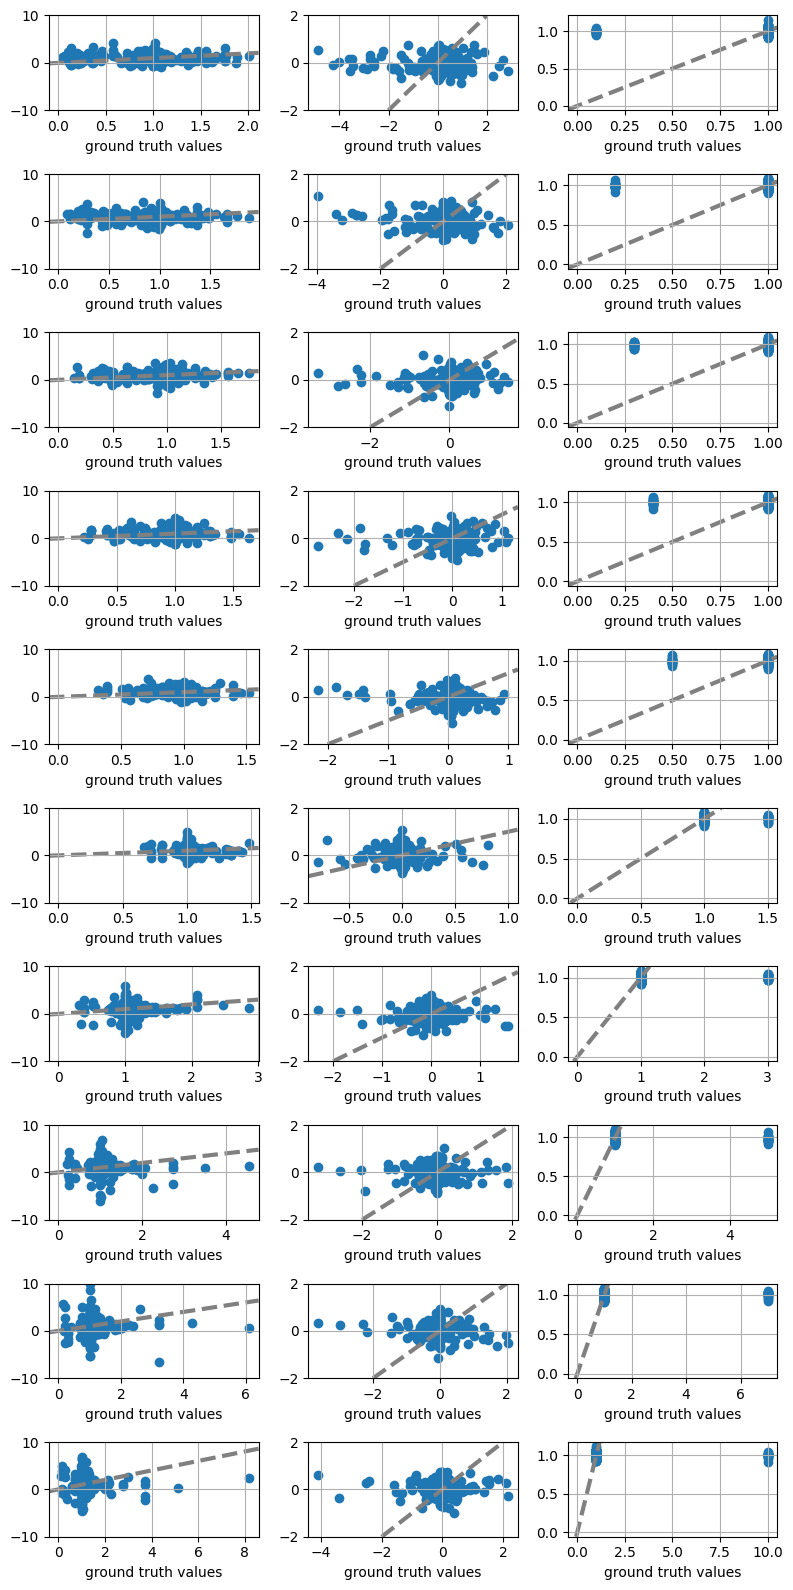

In [49]:
# Create two subplots and unpack the output array immediately
f, ax = plt.subplots(10, 3, figsize=(8,16))

for i in range(10):

    # ax[i,0].set_aspect('equal', 'datalim')
    ax[i,0].scatter(bmca_objs[i].vn.values, v_ppcs[i].values.reshape((19,-1)))
    ax[i,0].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
    # ax[i,0].set_title('v_obs, ground truth vs. posterior predictive')
    ax[i,0].set_xlabel('ground truth values')
    # ax[i,0].set_ylabel('predicted values')
    ax[i,0].grid()
    ax[i,0].set_ylim((-10,10))

    # ax[i,1].set_aspect('equal', 'datalim')
    ax[i,1].scatter(bmca_objs[i].xn.values, x_ppcs[i].values.reshape((13,-1)))
    ax[i,1].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
    # ax[i,1].set_title('chi_obs, ground truth vs. posterior predictive')
    ax[i,1].set_xlabel('ground truth values')
    ax[i,1].grid()
    ax[i,1].set_ylim((-2,2))

    # ax[i,1].set_aspect('equal', 'datalim')
    ax[i,2].scatter(bmca_objs[i].en.values, e_ppcs[i].values.reshape((19,-1)))
    ax[i,2].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
    # ax[i,1].set_title('chi_obs, ground truth vs. posterior predictive')
    ax[i,2].set_xlabel('ground truth values')
    ax[i,2].grid()
    


f.tight_layout()

# f.suptitle('BMCA on Topology B by perturbation, allData')

### Elasticity check 

In [6]:
Ex01_advi = util.get_az_summary(trace01)
Ex02_advi = util.get_az_summary(trace02)
Ex03_advi = util.get_az_summary(trace03)
Ex04_advi = util.get_az_summary(trace04)
Ex05_advi = util.get_az_summary(trace05)

Ex15_advi = util.get_az_summary(trace15)
Ex3_advi = util.get_az_summary(trace3)
Ex5_advi = util.get_az_summary(trace5)
Ex7_advi = util.get_az_summary(trace7)
Ex100_advi = util.get_az_summary(trace100)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [7]:
vEx01_advi = util.get_az_summary(vtrace01)
vEx02_advi = util.get_az_summary(vtrace02)
vEx03_advi = util.get_az_summary(vtrace03)
vEx04_advi = util.get_az_summary(vtrace04)
vEx05_advi = util.get_az_summary(vtrace05)

vEx15_advi = util.get_az_summary(vtrace15)
vEx3_advi = util.get_az_summary(vtrace3)
vEx5_advi = util.get_az_summary(vtrace5)
vEx7_advi = util.get_az_summary(vtrace7)
vEx100_advi = util.get_az_summary(vtrace100)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [8]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                    -Ex01_advi, 
                                    -Ex02_advi, 
                                    -Ex03_advi, 
                                    -Ex04_advi, 
                                    -Ex05_advi,  
                                    -Ex15_advi,
                                    -Ex3_advi, 
                                    -Ex5_advi, 
                                    -Ex7_advi, 
                                    -Ex100_advi])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels,
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyB-noReg_allData_elasticities.csv')

In [9]:
velasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                    vEx01_advi, 
                                    vEx02_advi, 
                                    vEx03_advi, 
                                    vEx04_advi, 
                                    vEx05_advi,  
                                    vEx15_advi,
                                    vEx3_advi, 
                                    vEx5_advi, 
                                    vEx7_advi, 
                                    vEx100_advi])

velasticities_df = pd.DataFrame(velasticity_values, columns=['gt']+pt_labels,
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyB-noReg_allData_elasticities.csv')

In [10]:
e_slopes = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

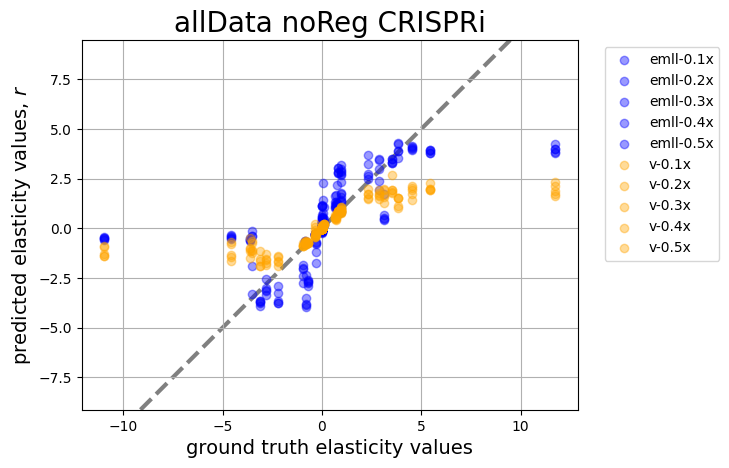

In [11]:
plt.axes().set_aspect('equal', 'datalim')
# plt.scatter(elasticities_df['gt'], elasticities_df['knockout'], alpha=0.4, label='knockout', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='emll-0.1x', zorder=10, c='b')
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='emll-0.2x', zorder=10, c='b')
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='emll-0.3x', zorder=10, c='b')
plt.scatter(elasticities_df['gt'], elasticities_df['0.4x'], alpha=0.4, label='emll-0.4x', zorder=10, c='b')
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='emll-0.5x', zorder=10, c='b')

plt.scatter(velasticities_df['gt'], velasticities_df['0.1x'], alpha=0.4, label='v-0.1x', zorder=10, c='orange')
plt.scatter(velasticities_df['gt'], velasticities_df['0.2x'], alpha=0.4, label='v-0.2x', zorder=10, c='orange')
plt.scatter(velasticities_df['gt'], velasticities_df['0.3x'], alpha=0.4, label='v-0.3x', zorder=10, c='orange')
plt.scatter(velasticities_df['gt'], velasticities_df['0.4x'], alpha=0.4, label='v-0.4x', zorder=10, c='orange')
plt.scatter(velasticities_df['gt'], velasticities_df['0.5x'], alpha=0.4, label='v-0.5x', zorder=10, c='orange')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('allData noReg CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.savefig('../../../visualize/raw_svg_figures/cowboy_elasticities-1.svg', format="svg")

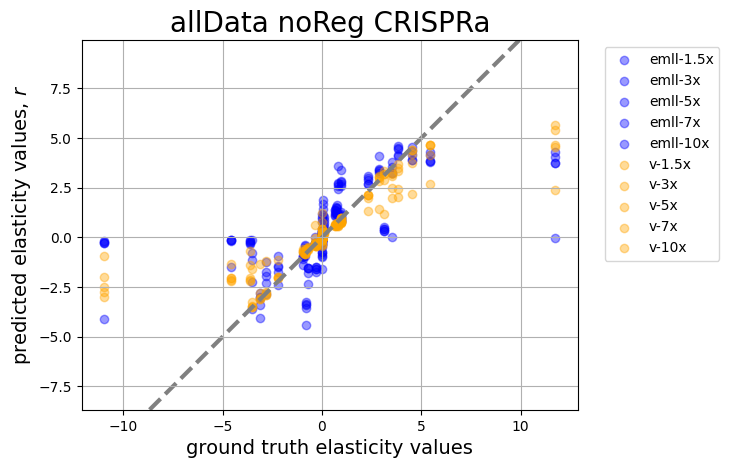

In [12]:
plt.axes().set_aspect('equal', 'datalim')
# plt.scatter(elasticities_df['gt'], elasticities_df['1.01x'], alpha=0.4, label='1.01x')
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='emll-1.5x', c='b')
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='emll-3x', c='b')
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='emll-5x', c='b')
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='emll-7x', c='b')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='emll-10x', c='b')

plt.scatter(velasticities_df['gt'], velasticities_df['1.5x'], alpha=0.4, label='v-1.5x', c='orange')
plt.scatter(velasticities_df['gt'], velasticities_df['3x'], alpha=0.4, label='v-3x', c='orange')
plt.scatter(velasticities_df['gt'], velasticities_df['5x'], alpha=0.4, label='v-5x', c='orange')
plt.scatter(velasticities_df['gt'], velasticities_df['7x'], alpha=0.4, label='v-7x', c='orange')
plt.scatter(velasticities_df['gt'], velasticities_df['10x'], alpha=0.4, label='v-10x', c='orange')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('allData noReg CRISPRa', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.savefig('../../../visualize/raw_svg_figures/cowboy_elasticities-2.svg', format="svg")

In [22]:
# first drop the gt column
emll_subset = elasticities_df.drop('gt', axis=1)
# calculate the min and max of all the columns
emll_subset['min'] = emll_subset.min(axis=1)
emll_subset['max'] = emll_subset.max(axis=1)
# calculate the median of all the columns
emll_subset['median'] = emll_subset.median(axis=1)
emll_subset.head()

ela_lower_y = np.array(emll_subset['median']) - np.array(emll_subset['min'])
ela_upper_y = np.array(emll_subset['max']) - np.array(emll_subset['median'])
emll_errors = [ela_lower_y, ela_upper_y]

In [21]:
# first drop the gt column
v_subset = velasticities_df.drop('gt', axis=1)
# calculate the min and max of all the columns
v_subset['min'] = v_subset.min(axis=1)
v_subset['max'] = v_subset.max(axis=1)
# calculate the median of all the columns
v_subset['median'] = v_subset.median(axis=1)
v_subset.head()

vela_lower_y = np.array(v_subset['median']) - np.array(v_subset['min'])
vela_upper_y = np.array(v_subset['max']) - np.array(v_subset['median'])
vela_errors = [vela_lower_y, vela_upper_y]

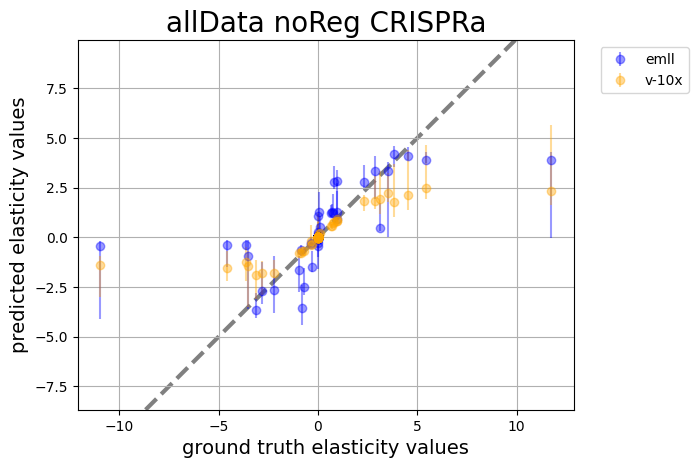

In [ ]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(elasticities_df['gt'], emll_subset['median'], yerr=emll_errors, fmt='o', alpha=0.4, label='emll', c='blue')
plt.errorbar(velasticities_df['gt'], v_subset['median'], yerr=vela_errors, fmt='o', alpha=0.4, label='v-based', c='orange')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values', size=14)
plt.title('allData noReg CRISPRa', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.savefig('../../../visualize/raw_svg_figures/cowboy_elasticities-2.svg', format="svg")

## Calculating control coefficients

## Calculating CCC values and making graphs

In [26]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())

### posteriors

In [27]:
# all data
postCCC01 = -util.estimate_CCCs(BMCA_obj01, Ex01_advi.reshape((19, -1)))
postCCC02 = -util.estimate_CCCs(BMCA_obj02, Ex02_advi.reshape((19, -1)))
postCCC03 = -util.estimate_CCCs(BMCA_obj03, Ex03_advi.reshape((19, -1)))
postCCC04 = -util.estimate_CCCs(BMCA_obj04, Ex04_advi.reshape((19, -1)))
postCCC05 = -util.estimate_CCCs(BMCA_obj05, Ex05_advi.reshape((19, -1)))
postCCC15 = -util.estimate_CCCs(BMCA_obj15, Ex15_advi.reshape((19, -1)))
postCCC3 = -util.estimate_CCCs(BMCA_obj3, Ex3_advi.reshape((19, -1)))
postCCC5 = -util.estimate_CCCs(BMCA_obj5, Ex5_advi.reshape((19, -1)))
postCCC7 = -util.estimate_CCCs(BMCA_obj7, Ex7_advi.reshape((19, -1)))
postCCC100 = -util.estimate_CCCs(BMCA_obj100, Ex100_advi.reshape((19, -1)))

postCCCs = [postCCC01, postCCC02, postCCC03, postCCC04, postCCC05, postCCC15, postCCC3, postCCC5, postCCC7, postCCC100]

postCCC_meds = [-pd.DataFrame(np.median(postCCC, axis=0), columns=r.getReactionIds(), index=r.getFloatingSpeciesIds()) for postCCC in postCCCs]
postCCC_meds = pd.concat([i.melt()['value'] for i in postCCC_meds], axis=1).values
postCCC_meds = pd.DataFrame(postCCC_meds, columns=pt_labels)
postCCC_meds['median'] = postCCC_meds.median(axis=1)
postCCC_meds['min'] = postCCC_meds.min(axis=1)
postCCC_meds['max'] = postCCC_meds.max(axis=1)

CCC_lower_y_post = np.array(postCCC_meds['median']) - np.array(postCCC_meds['min'])
CCC_upper_y_post = np.array(postCCC_meds['max']) - np.array(postCCC_meds['median'])
CCC_errors_post = [CCC_lower_y_post, CCC_upper_y_post]

In [28]:
# all data
vpostCCC01 = util.estimate_CCCs(BMCA_obj01, vEx01_advi.reshape((19, -1)))
vpostCCC02 = util.estimate_CCCs(BMCA_obj02, vEx02_advi.reshape((19, -1)))
vpostCCC03 = util.estimate_CCCs(BMCA_obj03, vEx03_advi.reshape((19, -1)))
vpostCCC04 = util.estimate_CCCs(BMCA_obj04, vEx04_advi.reshape((19, -1)))
vpostCCC05 = util.estimate_CCCs(BMCA_obj05, vEx05_advi.reshape((19, -1)))
vpostCCC15 = util.estimate_CCCs(BMCA_obj15, vEx15_advi.reshape((19, -1)))
vpostCCC3 = util.estimate_CCCs(BMCA_obj3, vEx3_advi.reshape((19, -1)))
vpostCCC5 = util.estimate_CCCs(BMCA_obj5, vEx5_advi.reshape((19, -1)))
vpostCCC7 = util.estimate_CCCs(BMCA_obj7, vEx7_advi.reshape((19, -1)))
vpostCCC100 = util.estimate_CCCs(BMCA_obj100, vEx100_advi.reshape((19, -1)))

vpostCCCs = [vpostCCC01, vpostCCC02, vpostCCC03, vpostCCC04, vpostCCC05, vpostCCC15, vpostCCC3, vpostCCC5, vpostCCC7, vpostCCC100]

vpostCCC_meds = [-pd.DataFrame(np.median(vpostCCC, axis=0), columns=r.getReactionIds(), index=r.getFloatingSpeciesIds()) for vpostCCC in vpostCCCs]
vpostCCC_meds = pd.concat([i.melt()['value'] for i in vpostCCC_meds], axis=1).values
vpostCCC_meds = pd.DataFrame(vpostCCC_meds, columns=pt_labels)
vpostCCC_meds['median'] = vpostCCC_meds.median(axis=1)
vpostCCC_meds['min'] = vpostCCC_meds.min(axis=1)
vpostCCC_meds['max'] = vpostCCC_meds.max(axis=1)

vCCC_lower_y_post = np.array(vpostCCC_meds['median']) - np.array(vpostCCC_meds['min'])
vCCC_upper_y_post = np.array(vpostCCC_meds['max']) - np.array(vpostCCC_meds['median'])
vCCC_errors_post = [vCCC_lower_y_post, vCCC_upper_y_post]

### CCC graphs

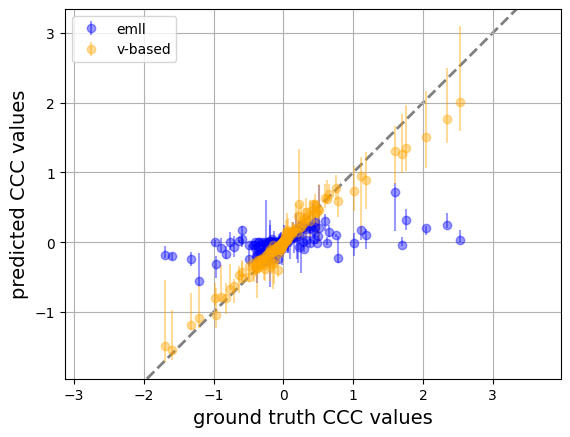

In [29]:
plt.axes().set_aspect('equal', 'datalim')


plt.errorbar(gtCCC.melt()['value'], postCCC_meds['median'], yerr=CCC_errors_post, alpha=0.4, fmt='o', label='emll', zorder=100, c='b')
plt.errorbar(gtCCC.melt()['value'], vpostCCC_meds['median'], yerr=vCCC_errors_post, alpha=0.4, fmt='o', label='v-based', zorder=100, c='orange')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth CCC values', size=14)
plt.ylabel('predicted CCC values', size=14)
plt.savefig('../../../visualize/raw_svg_figures/cowboy_CCCs.svg', format="svg")

Text(0, 0.5, 'predicted CCC values')

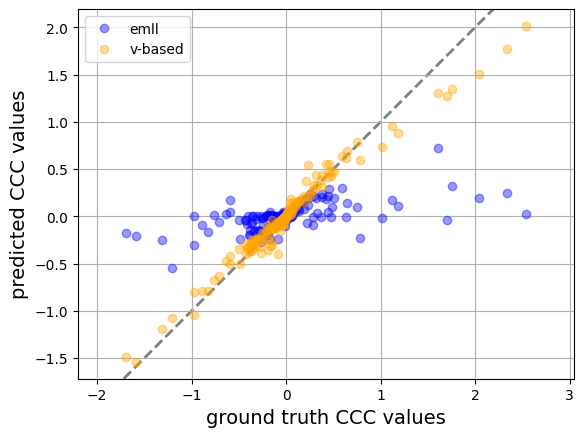

In [38]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtCCC.melt()['value'], postCCC_meds['median'], alpha=0.4, fmt='o', label='emll', zorder=100, c='b')
plt.errorbar(gtCCC.melt()['value'], vpostCCC_meds['median'], alpha=0.4, fmt='o', label='v-based', zorder=100, c='orange')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth CCC values', size=14)
plt.ylabel('predicted CCC values', size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianCCCs.svg', format="svg")

## Calculating FCCs

In [31]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [32]:
postFCC01 = util.estimate_FCCs(BMCA_obj01, Ex01_advi.reshape((19,-1)))
postFCC02 = util.estimate_FCCs(BMCA_obj02, Ex02_advi.reshape((19,-1)))
postFCC03 = util.estimate_FCCs(BMCA_obj03, Ex03_advi.reshape((19,-1)))
postFCC04 = util.estimate_FCCs(BMCA_obj04, Ex04_advi.reshape((19,-1)))
postFCC05 = util.estimate_FCCs(BMCA_obj05, Ex05_advi.reshape((19,-1)))

postFCC15 = util.estimate_FCCs(BMCA_obj15, Ex15_advi.reshape((19,-1)))
postFCC3 = util.estimate_FCCs(BMCA_obj3, Ex3_advi.reshape((19,-1)))
postFCC5 = util.estimate_FCCs(BMCA_obj5, Ex5_advi.reshape((19,-1)))
postFCC7 = util.estimate_FCCs(BMCA_obj7, Ex7_advi.reshape((19,-1)))
postFCC100 = util.estimate_FCCs(BMCA_obj100, Ex100_advi.reshape((19,-1)))

post_FCCs = [postFCC01, postFCC02, postFCC03, postFCC04, postFCC05, postFCC15, postFCC3, postFCC5, postFCC7, postFCC100]

postFCC_meds = [-pd.DataFrame(np.median(postFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()) for postFCC in post_FCCs]
postFCC_meds = pd.concat([i.melt()['value'] for i in postFCC_meds], axis=1).values
postFCC_meds = pd.DataFrame(postFCC_meds, columns=pt_labels)
postFCC_meds['median'] = postFCC_meds.median(axis=1)
postFCC_meds['min'] = postFCC_meds.min(axis=1)
postFCC_meds['max'] = postFCC_meds.max(axis=1)
# postFCC_meds

FCC_lower_y_post = np.array(postFCC_meds['median']) - np.array(postFCC_meds['min'])
FCC_upper_y_post = np.array(postFCC_meds['max']) - np.array(postFCC_meds['median'])
FCC_errors_post = [FCC_lower_y_post, FCC_upper_y_post]

In [33]:
vpostFCC01 = util.estimate_FCCs(BMCA_obj01, vEx01_advi.reshape((19,-1)))
vpostFCC02 = util.estimate_FCCs(BMCA_obj02, vEx02_advi.reshape((19,-1)))
vpostFCC03 = util.estimate_FCCs(BMCA_obj03, vEx03_advi.reshape((19,-1)))
vpostFCC04 = util.estimate_FCCs(BMCA_obj04, vEx04_advi.reshape((19,-1)))
vpostFCC05 = util.estimate_FCCs(BMCA_obj05, vEx05_advi.reshape((19,-1)))

vpostFCC15 = util.estimate_FCCs(BMCA_obj15, vEx15_advi.reshape((19,-1)))
vpostFCC3 = util.estimate_FCCs(BMCA_obj3, vEx3_advi.reshape((19,-1)))
vpostFCC5 = util.estimate_FCCs(BMCA_obj5, vEx5_advi.reshape((19,-1)))
vpostFCC7 = util.estimate_FCCs(BMCA_obj7, vEx7_advi.reshape((19,-1)))
vpostFCC100 = util.estimate_FCCs(BMCA_obj100, vEx100_advi.reshape((19,-1)))

vpost_FCCs = [vpostFCC01, vpostFCC02, vpostFCC03, vpostFCC04, vpostFCC05, vpostFCC15, vpostFCC3, vpostFCC5, vpostFCC7, vpostFCC100]

vpostFCC_meds = [-pd.DataFrame(np.median(vpostFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()) for vpostFCC in vpost_FCCs]
vpostFCC_meds = pd.concat([i.melt()['value'] for i in vpostFCC_meds], axis=1).values
vpostFCC_meds = pd.DataFrame(vpostFCC_meds, columns=pt_labels)
vpostFCC_meds['median'] = vpostFCC_meds.median(axis=1)
vpostFCC_meds['min'] = vpostFCC_meds.min(axis=1)
vpostFCC_meds['max'] = vpostFCC_meds.max(axis=1)
# vpostFCC_meds

vFCC_lower_y_post = np.array(vpostFCC_meds['median']) - np.array(vpostFCC_meds['min'])
vFCC_upper_y_post = np.array(vpostFCC_meds['max']) - np.array(vpostFCC_meds['median'])
vFCC_errors_post = [vFCC_lower_y_post, vFCC_upper_y_post]

## FCC graphs

In [34]:
## adding corrections 
rxn = np.repeat(r.getReactionIds(),len(r.getReactionIds()))
enz_pt = r.getReactionIds() * len(r.getReactionIds())
FCC_idx = pd.DataFrame([rxn, enz_pt]).T

pt_enz_is_rxn = np.linspace(0,len(rxn)-1,len(r.getReactionIds()))
pt_enz_is_rxn

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.,
       220., 240., 260., 280., 300., 320., 340., 360.])

In [35]:
postFCC_meds.loc[pt_enz_is_rxn, 'median'] += 2
vpostFCC_meds.loc[pt_enz_is_rxn, 'median'] += 2

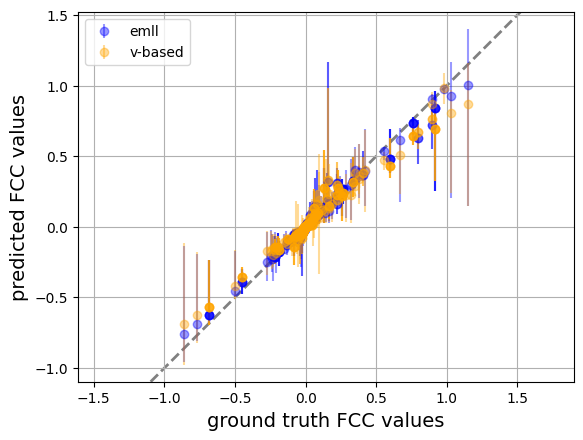

In [36]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC.melt()['value'], postFCC_meds['median'], yerr=FCC_errors_post, alpha=0.4, fmt='o', label='emll', zorder=100, c='b')
plt.errorbar(gtFCC.melt()['value'], vpostFCC_meds['median'], yerr=vFCC_errors_post, alpha=0.4, fmt='o', label='v-based', zorder=100, c='orange')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)
plt.savefig('../../../visualize/raw_svg_figures/cowboy_FCCs.svg', format="svg")

Text(0, 0.5, 'predicted FCC values')

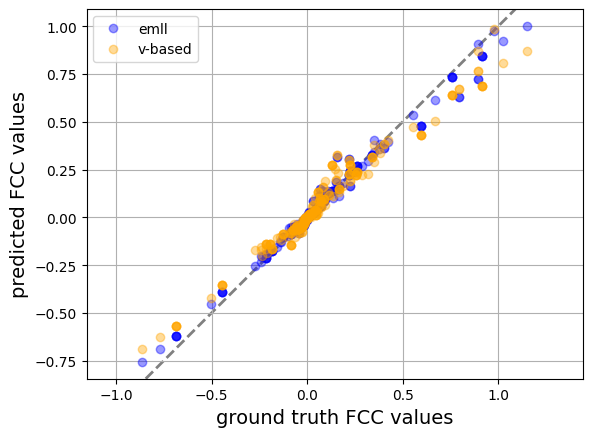

In [37]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC.melt()['value'], postFCC_meds['median'], alpha=0.4, fmt='o', label='emll', zorder=100, c='b')
plt.errorbar(gtFCC.melt()['value'], vpostFCC_meds['median'], alpha=0.4, fmt='o', label='v-based', zorder=100, c='orange')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_wCorrection.svg', format="svg")